In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:77% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import time
import pickle
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from collections import OrderedDict
from net.st_gcn import Model
from feeder.feeder import Feeder
from torchlight.io import IO
from ad_utils import map2ind, loader_initializer
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=100, precision=5, suppress=True)

In [3]:
# Loading of original weights
data_dir_path = '/root/sharedfolder/datasets/data_ssd/kinetics-skeleton/st-gcn_kinetics/Kinetics/kinetics-skeleton/'
root_path = '/root/sharedfolder/Research/pose_ad/st-gcn/'
weights_path =  os.path.join(root_path, 'models/kinetics-st_gcn.pt')
ft_weights_path = os.path.join(root_path, 'models/kinetics-st_gcn_ft.pt')
io = IO(root_path)
model_name = 'net.st_gcn.Model'
graph_args = {'layout':'openpose', 'strategy':'spatial'}
model_args = {
    'edge_importance_weighting':True,
    'graph_args':graph_args,
    'in_channels':3,
    'num_class':4, }

In [4]:
model = io.load_model(model_name, **model_args)

In [5]:
# Need to turn into a func
weights = torch.load(weights_path)
weights_list = [[k.split('module.')[-1], v.cpu()] for k, v in weights.items()]
weights = OrderedDict(weights_list)
model_state_dict = model.state_dict()
weights.pop('fcn.bias') # loading all but the Final FC layer's weight and bias
weights.pop('fcn.weight')
model_state_dict.update(weights)
model.load_state_dict(model_state_dict)

In [6]:
# Freezing of layers for fine tuning
for name, param in model.named_parameters():
    param.requires_grad = False
    if "fcn" in name:  # Keeping the last FC layer trainable
        param.requires_grad = True
#     if name.find('9') != -1:  # For adding an additional graph conv layer to the training
#         param.requires_grad = True

In [7]:
data_path   = dict()
label_path  = dict()
data_loader = dict()
feeder_args = dict()

In [8]:
train_data_path = os.path.join(data_dir_path, 'train_data.npy')
train_label_path = os.path.join(data_dir_path, 'train_label.pkl')
test_data_path = os.path.join(data_dir_path, 'val_data.npy')
test_label_path = os.path.join(data_dir_path, 'val_label.pkl')

In [9]:
normal_classes = [30, 74, 22, 15]
# for split in ['normal_train', 'normal_test', 'mixed_test']:
#     data_path[split]   =  os.path.join(data_dir_path, 'ad_experiment', split+'_data.npy')
#     label_path[split]  =  os.path.join(data_dir_path, 'ad_experiment', split+'_label.pkl')
#     feeder_args[split] = {'data_path': data_path[split], 'label_path': label_path[split]}
    
feeder_args['random_train'] = {'data_path': train_data_path, 'label_path': train_label_path, 'specify_classes':normal_classes}
feeder_args['random_test'] = {'data_path': test_data_path, 'label_path': test_label_path}  #, 'specify_classes':normal_classes}

In [10]:
batch_size=32
# data_loader['normal_train'] = loader_initializer(feeder_args['normal_train'], batch_size=batch_size)
# data_loader['normal_test' ] = loader_initializer(feeder_args['normal_test' ], batch_size=batch_size, drop_last=False)
# data_loader['mixed_test'  ] = loader_initializer(feeder_args['mixed_test'  ], batch_size=batch_size, suffle=False, drop_last=False)

data_loader['random_train' ] = loader_initializer(feeder_args['random_train' ], batch_size=batch_size, drop_last=True)
data_loader['random_test'  ] = loader_initializer(feeder_args['random_test'  ], batch_size=batch_size, suffle=True, drop_last=False)

In [11]:
# Model Definitions for Training
dev = 'cuda:0'
model = model.to(dev)
loss_fn = nn.CrossEntropyLoss()
# loader = data_loader['normal_train']
loader = data_loader['random_train']
loss_th = 0.15

In [12]:
optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

In [13]:
model_filename = 'models/kinetics-nc{}_curr.pt'.format(len(normal_classes))
curr_weights_path = os.path.join(root_path, model_filename)

In [14]:
# Training Loop
train = 2 # 0 - Not, 1 - Train only, 2 - Train and Save

if train >= 1:
    for epoch in range(4):
        for itern, [data, label] in enumerate(loader):
                # get data
                data = data.float().to(dev)
                label = torch.from_numpy(map2ind(label))
                label = label.long().to(dev)

                # forward
                output = model(data)
                loss = loss_fn(output, label)

                # backward
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if itern%10 == 0: 
                    print("Iteration {} (Epoch: {}), loss is {}".format(itern, epoch, loss))
                if loss < loss_th:
                    print("Met loss {} in Epoch {}, iteration {}".format(loss, epoch, itern))
                    break
        else:
            continue
        break
    print("Done")
if train == 2:
    torch.save(model.state_dict(), curr_weights_path)

Iteration 0 (Epoch: 0), loss is 1.353910207748413
Iteration 10 (Epoch: 0), loss is 1.336286187171936
Iteration 20 (Epoch: 0), loss is 0.9653661251068115
Iteration 30 (Epoch: 0), loss is 0.9475481510162354
Iteration 40 (Epoch: 0), loss is 0.8236885070800781
Iteration 50 (Epoch: 0), loss is 0.6526684165000916
Iteration 60 (Epoch: 0), loss is 0.5776662230491638
Iteration 70 (Epoch: 0), loss is 0.5663155913352966
Iteration 0 (Epoch: 1), loss is 0.3762049078941345
Iteration 10 (Epoch: 1), loss is 0.42019519209861755
Iteration 20 (Epoch: 1), loss is 0.4635215699672699
Iteration 30 (Epoch: 1), loss is 0.41238880157470703
Iteration 40 (Epoch: 1), loss is 0.36050087213516235
Iteration 50 (Epoch: 1), loss is 0.3235246539115906
Iteration 60 (Epoch: 1), loss is 0.34993988275527954
Iteration 70 (Epoch: 1), loss is 0.26971614360809326
Iteration 0 (Epoch: 2), loss is 0.275116503238678
Iteration 10 (Epoch: 2), loss is 0.3378540575504303
Iteration 20 (Epoch: 2), loss is 0.3760155141353607
Iteration 30 

In [15]:
# For output evaluation
if train >= 1:
    sfmax_vals, cls = torch.max(output, 1)
    print("Correct predictions\n {}".format(cls==label))
    softmax = nn.Softmax(dim=1)
    osoftmax_gpu = softmax(output)

    sfmax_vals, cls = torch.max(osoftmax_gpu, 1)

    osoftmax = 100 * osoftmax_gpu.cpu().detach().numpy()
#     print("Softmax Outputs \n{} \nSofmax max values \n{}".format(osoftmax, sfmax_vals))
    torch.mean(sfmax_vals)

Correct predictions
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)


In [16]:
dev = 'cuda:0'
model_ld = io.load_model(model_name, **model_args)
model_ld.load_state_dict(torch.load(curr_weights_path))
model_ld.to(dev)
model_ld.eval()

Model(
  (data_bn): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (st_gcn_networks): ModuleList(
    (0): st_gcn(
      (gcn): ConvTemporalGraphical(
        (conv): Conv2d(3, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (tcn): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0, inplace)
      )
      (relu): ReLU(inplace)
    )
    (1): st_gcn(
      (gcn): ConvTemporalGraphical(
        (conv): Conv2d(64, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (tcn): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4

In [17]:
# Model Definitions for Testing
# loader = data_loader['mixed_test']
loader = data_loader['random_test']
model = model_ld
model.eval()

Model(
  (data_bn): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (st_gcn_networks): ModuleList(
    (0): st_gcn(
      (gcn): ConvTemporalGraphical(
        (conv): Conv2d(3, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (tcn): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0, inplace)
      )
      (relu): ReLU(inplace)
    )
    (1): st_gcn(
      (gcn): ConvTemporalGraphical(
        (conv): Conv2d(64, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (tcn): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4

In [26]:
loss_value = []
result_frag = []
label_frag = []
label_ad = np.empty(0)
outputs = []
epoch_info = dict()
confusion_mat = np.zeros([5,5], dtype=np.int32)
evaluation = True
softmax = nn.Softmax(dim=1)

for itern, [data, label_ld] in enumerate(loader):
    # get data
    data = data.float().cuda()
    label_ad_curr = map2ind(label_ld, from_arr=normal_classes, to_arr=np.ones_like(normal_classes), def_val=0)
    label_ad = np.concatenate((label_ad, label_ad_curr))
    label_mapped = map2ind(label_ld, from_arr=normal_classes, to_arr=None, def_val=0) # Assign output probs regardless of abnormal classes,
    label = torch.from_numpy(label_mapped)

    label = label.long().cuda()

    # inference
    with torch.no_grad():
        output = model(data)
    result_frag.append(output.data.cpu().numpy())

    # get loss
    if evaluation:
        loss = loss_fn(output, label)
#         confusion_mat[label_mapped, np.argmax(output, axis=1)] += 1
#         loss_value.append(loss.data[0])
        label_frag.append(label.data.cpu().numpy())
        outputs.append([itern ,softmax(output).data.cpu().numpy()])

    # Track progress
    if itern % 50 == 0:
        print("Iteration {}".format(itern))
    # Stop
    if itern == 500:
        break

result = np.concatenate(result_frag)
# np.savetxt("kinetics400_confusion.csv", confusion_mat)
if evaluation:
    label2 = np.concatenate(label_frag)
    epoch_info['mean_loss'] = np.mean(loss_value)

Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 500


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f8289dd0b00>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/usr/local/lib/python3.5/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File

In [28]:
label_ad.shape

(16032,)

In [29]:
len(outputs)
out_sfmax = [np.array(sf) for i, sf in outputs]
out_sfmax = np.concatenate(out_sfmax, axis=0)
out_sfmax_max_vals = out_sfmax.max(axis=1)
split_idx = 198
normal_max_sfmax = out_sfmax_max_vals[label_ad == 1]
abnormal_max_sfmax = out_sfmax_max_vals[label_ad == 0]
print(normal_max_sfmax.mean(), abnormal_max_sfmax.mean())

0.7936247 0.68401027


In [30]:
# For output evaluation
sfmax_vals, cls = torch.max(output, 1)
print("Correct predictions\n {}".format(cls==label))
softmax = nn.Softmax(dim=1)
osoftmax_gpu = softmax(output)

sfmax_vals, cls = torch.max(osoftmax_gpu, 1)

osoftmax = 100 * osoftmax_gpu.cpu().detach().numpy()
print("Softmax Outputs \n{} \nSofmax max values \n{}".format(osoftmax, sfmax_vals))
torch.mean(sfmax_vals)
label
# print("Correct predictions\n {}".format(cls_bn==label))


Correct predictions
 tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0', dtype=torch.uint8)
Softmax Outputs 
[[13.81801 34.12931  4.29795 47.75475]
 [15.31688 42.85121 21.37346 20.45845]
 [46.35085 10.06052 33.75373  9.8349 ]
 [14.76985  2.29571  2.74723 80.18721]
 [ 7.75083  1.66602 86.58537  3.99778]
 [ 7.68746  7.27262 19.84185 65.19806]
 [17.89087 26.04573 45.10905 10.95434]
 [ 7.58863 50.07758  9.81072 32.52309]
 [59.74096  7.33461 25.20918  7.71524]
 [87.51398  0.18372  2.35238  9.94992]
 [15.2642   5.24221 73.47461  6.01898]
 [47.11449  4.75482 43.70334  4.42736]
 [20.30817 47.36475 16.68689 15.6402 ]
 [ 5.08321  8.13469 10.29965 76.48246]
 [ 3.99515  1.35391 83.54682 11.10411]
 [ 5.47435 63.51363 19.96676 11.04527]
 [ 7.19495 50.07774 12.34617 30.38114]
 [ 2.25397 16.56493 80.10133  1.07978]
 [52.06236 14.50983  2.33272 31.0951 ]
 [21.15195 12.51193  1.99634 64.33978]
 [ 4.70428 74.22443  5.74089 15.3

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [31]:
from sklearn.metrics import roc_curve, auc

true_labels = label_ad
fpr, tpr, thresholds = roc_curve(true_labels, out_sfmax_max_vals)
roc_auc = auc(fpr, tpr)

roc_auc

0.6785634686869959

In [32]:
# Log To Text File
log_str = "Results for classes {}\nfpr: {}\ntpr: {}\nthr: {}".format(normal_classes, fpr[::20], tpr[::20], thresholds[::20])
# print(log_str)
normal_classes_str = [str(i) for i in normal_classes]
classes_str = '_'.join(normal_classes_str)
time_str = time.strftime("%b%d_%H%M")
log_filename = "{}_{}_auc{}.txt".format(time_str, classes_str, str(int(100*roc_auc)))
log_dirname = 'logs/kinetics_trained_n_v_all/'
logfile_path = os.path.join(root_path, log_dirname, log_filename)
with open(logfile_path, 'w') as f:
    f.write(log_str)

In [33]:
ind=95
print(tpr[ind], fpr[ind], thresholds[ind])

0.3125 0.10219254032258064 0.92117476


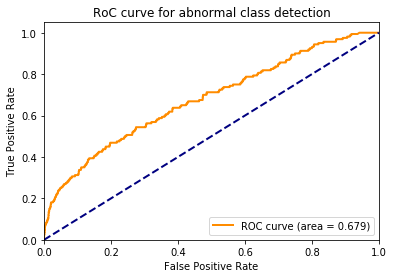

In [34]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RoC curve for abnormal class detection')
plt.legend(loc="lower right")
plt.show()

In [50]:
!python3 st-gcn-ad_n_v_all_exper.py

Experiment split 0, normal classes [312  92 260 181]
Iteration 0 (Epoch: 0), loss is 1.4863206148147583
Iteration 10 (Epoch: 0), loss is 1.198142647743225
Iteration 20 (Epoch: 0), loss is 1.000427484512329
Iteration 30 (Epoch: 0), loss is 0.8451233506202698
Iteration 40 (Epoch: 0), loss is 0.6721122860908508
Iteration 0 (Epoch: 1), loss is 0.7509787678718567
Iteration 10 (Epoch: 1), loss is 0.6556546092033386
Iteration 20 (Epoch: 1), loss is 0.5348088145256042
Iteration 30 (Epoch: 1), loss is 0.5415209531784058
Iteration 40 (Epoch: 1), loss is 0.5374873280525208
Iteration 0 (Epoch: 2), loss is 0.4417767822742462
Iteration 10 (Epoch: 2), loss is 0.422802209854126
Iteration 20 (Epoch: 2), loss is 0.44954001903533936
Iteration 30 (Epoch: 2), loss is 0.49613872170448303
Iteration 40 (Epoch: 2), loss is 0.33806145191192627
Done
Correct predictions
 tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.ui

Iteration 30 (Epoch: 2), loss is 0.3444449007511139
Iteration 40 (Epoch: 2), loss is 0.3522026240825653
Iteration 50 (Epoch: 2), loss is 0.344154417514801
Iteration 60 (Epoch: 2), loss is 0.32283246517181396
Iteration 70 (Epoch: 2), loss is 0.5324721336364746
Done
Correct predictions
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)
Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 500
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f41cc5e72e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
   